# NIR Tutorial 

When starting an image-based phenotyping project it is important to consider what the end goals of the project are.
This is important because the goals of the project will determine the the camera type, imaging layout, and will help to 
guide downstream analysis. If it was 
an experiment focused on drought of maize plants and your goal was to get information about water content of plants you
might want to take side-view and top-view images of a single plant with a near-infrared camera.

To run a NIR workflow over a single NIR image there are three required inputs:

1.  **Image:** NIR images are grayscale matrices (1 signal dimension).
In principle, image processing will work on any grayscale image with adjustments if images are well lit and
there is appreciable contrast difference between the object of interest and the background.
2.  **Output directory:** If debug mode is set to 'print' output images from each intermediate step are produced.
3.  **Image of estimated background:** Right now this is hardcoded into the workflow (different background at each zoom level) and not implemented as an argument.


In [1]:
import cv2
from plantcv import plantcv as pcv


In [2]:
class options:
    def __init__(self):
        self.image = "./img/original_image.jpg"
        self.debug = "plot"
        self.writeimg= False
        self.result = "nir_tutorial_results.json"
        self.outdir = "." # Store the output to the current directory
        
# Get options
args = options()

# Set debug to the global parameter 
pcv.params.debug = args.debug


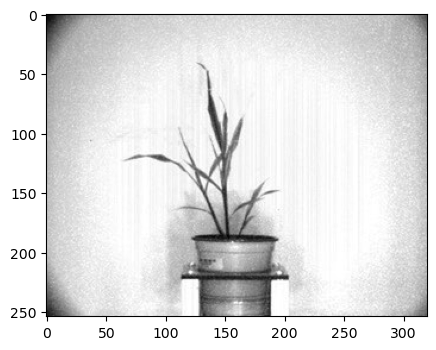

In [3]:
# Read image

# Inputs:
#   filename - Image file to be read in 
#   mode - How to read in the image; either 'native' (default), 'rgb', 'gray', or 'csv'
img, path, filename = pcv.readimage(filename=args.image)


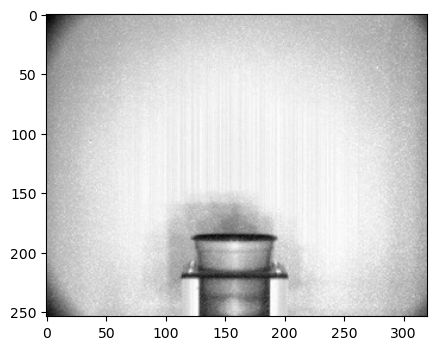

In [4]:
# Read in the background image 
img_bkgrd, bkgrd_path, bkgrd_filename = pcv.readimage(filename="./img/background_average.jpg")


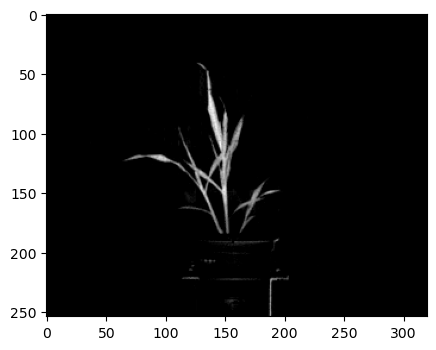

In [5]:
# Subtract the background image from the image with the plant. 

# Inputs: 
#   gray_img1 - Grayscale image data from which gray_img2 will be subtracted
#   gray_img2 - Grayscale image data which will be subtracted from gray_img1
bkg_sub_img = pcv.image_subtract(gray_img1=img_bkgrd, gray_img2=img)


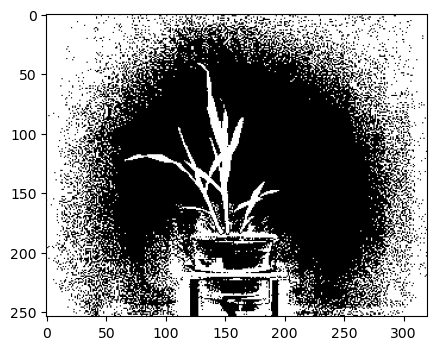

In [6]:
# There are often multiple ways to process images. There is also 
# a background subtraction function made that creates a binary 
# image from performing background subtraction on the foreground

# Inputs:
#   foreground_image - RGB or grayscale image data
#   background_image - RGB or grayscale image data 
fg_mask = pcv.background_subtraction(foreground_image=img, background_image=img_bkgrd)


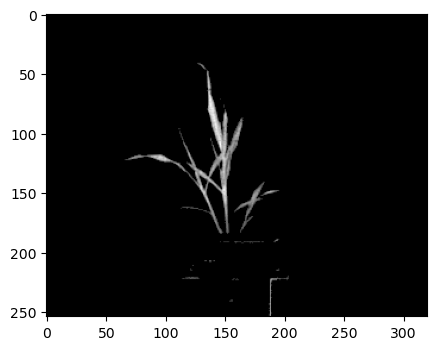

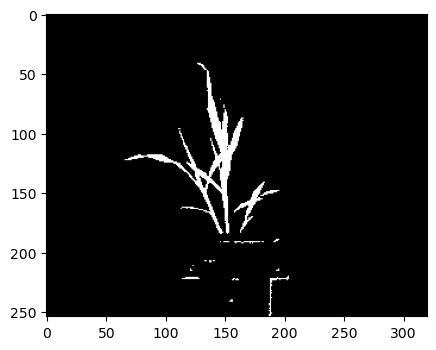

In [7]:
# Threshold the image of interest using the two-sided thresholding function (keep what is between 20-250) 
 
# Inputs:
#   rgb_img - RGB image data 
#   lower_thresh - List of lower threshold values 
#   upper_thresh - List of upper threshold values
#   channel - Color-space channels of interest (either 'RGB', 'HSV', 'LAB', or 'gray')
bkg_sub_thres_img, masked_img = pcv.threshold.custom_range(img=bkg_sub_img, lower_thresh=[20], 
                                                           upper_thresh=[250], channel='gray')



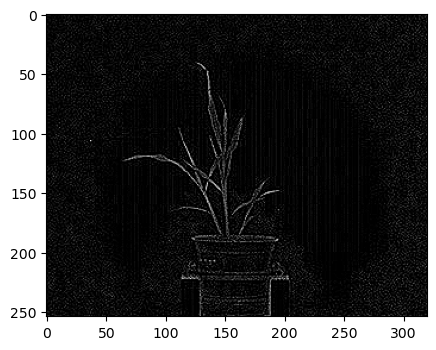

In [8]:
# Laplace filtering (identify edges based on 2nd derivative)

# Inputs:
#   gray_img - Grayscale image data 
#   ksize - Aperture size used to calculate the second derivative filter, 
#           specifies the size of the kernel (must be an odd integer)
#   scale - Scaling factor applied (multiplied) to computed Laplacian values 
#           (scale = 1 is unscaled) 
lp_img = pcv.laplace_filter(gray_img=img, ksize=1, scale=1)


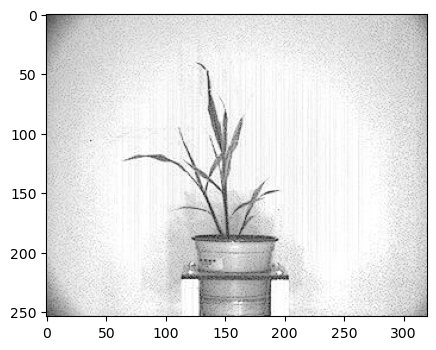

In [9]:
# Lapacian image sharpening, this step will enhance the darkness of the edges detected
lp_shrp_img = pcv.image_subtract(gray_img1=img, gray_img2=lp_img)


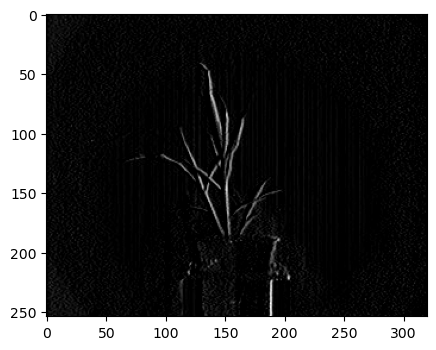

In [10]:
# Sobel filtering
# 1st derivative sobel filtering along horizontal axis, ksize = 1)

# Inputs: 
#   gray_img - Grayscale image data 
#   dx - Derivative of x to analyze 
#   dy - Derivative of y to analyze 
#   ksize - Aperture size used to calculate 2nd derivative, specifies the size of the kernel and must be an odd integer
# NOTE: Aperture size must be greater than the largest derivative (ksize > dx & ksize > dy) 
sbx_img = pcv.sobel_filter(gray_img=img, dx=1, dy=0, ksize=1)


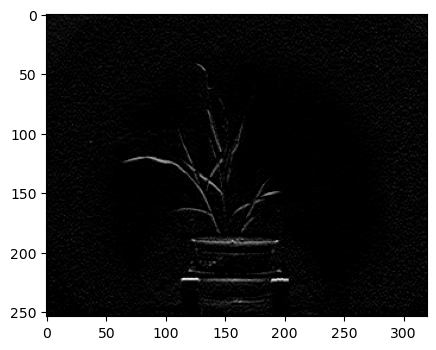

In [11]:
# 1st derivative sobel filtering along vertical axis, ksize = 1)

# Inputs:
#    gray_img - Grayscale image data
#    dx - derivative of x to analyze
#    dy - derivative of y to analyze 
#    ksize - apertures size used to calculate 2nd derivative filter, 
#    specifies the size of the kernel (must be an odd integer)
sby_img = pcv.sobel_filter(gray_img=img, dx=0, dy=1, ksize=1)


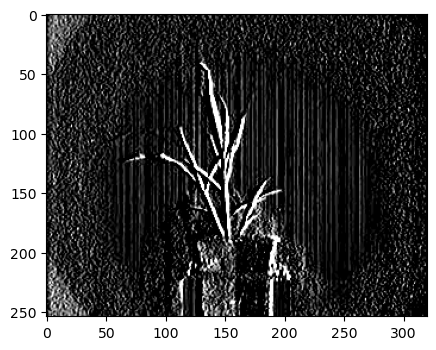

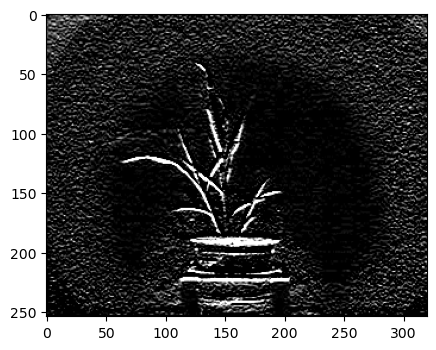

In [12]:
# Another function similar to the sobel filter is the scharr 
# filter. Depending on the image, one method might work a bit
# better than the other. Note dx+dy==1 must be satisfied. 

# Inputs:
#   img - RGB or grayscale image data 
#   dx - Derivative of x to analyze (0 or 1)
#   dy - Derivative of y to analyze (0 or 1)
#   scale - scaling factor applied (multiplied) to computed 
#           Scharr values (scale = 1 is unscaled)
scharrx_img = pcv.scharr_filter(img=img, dx=1, dy=0, scale=1)
scharry_img = pcv.scharr_filter(img=img, dx=0, dy=1, scale=1)


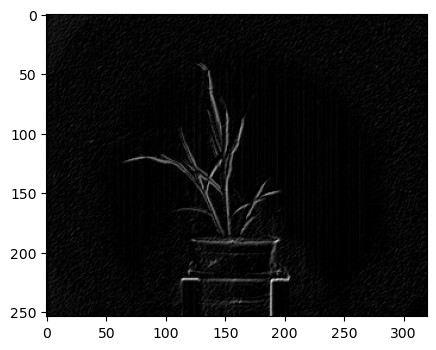

In [13]:
# Combine the effects of both x and y filters through matrix addition
# This will capture edges identified within each plane and emphasize edges found in both images

# Inputs:
#   gray_img1 - Grayscale image data to be added to gray_img2
#   gray_img2 - Grayscale image data to be added to gray_img1
sb_img = pcv.image_add(gray_img1=sbx_img, gray_img2=sby_img)


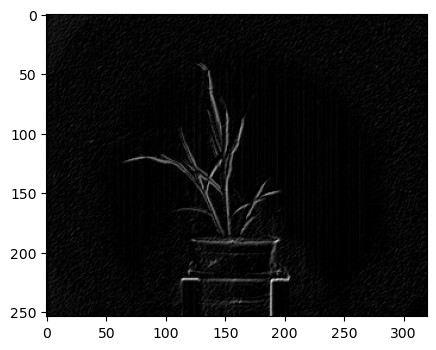

In [14]:
# Use a lowpass (blurring) filter to smooth sobel image

# Inputs:
#   gray_img - Grayscale image data 
#   ksize - Kernel size (integer or tuple), (ksize, ksize) box if integer input,
#           (n, m) box if tuple input 
mblur_img = pcv.median_blur(gray_img=sb_img, ksize=1)


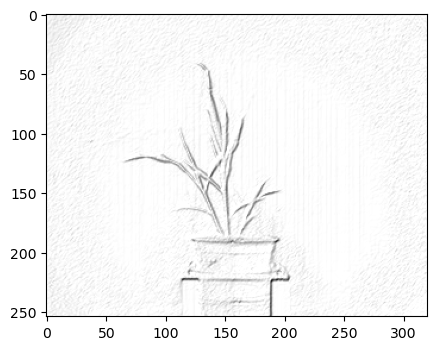

In [15]:
# Invert the image so our background is white 

# Inputs:
#   gray_img - Grayscale image data 
mblur_invert_img = pcv.invert(gray_img=mblur_img)


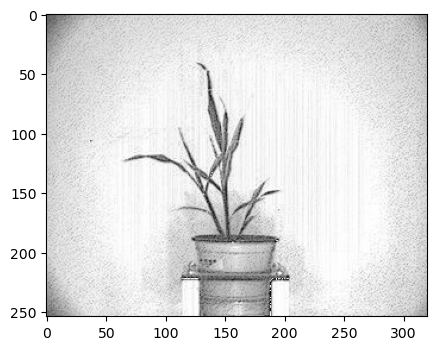

In [16]:
# Combine the smoothed sobel image with the laplacian sharpened image
# combines the best features of both methods as described in "Digital Image Processing" by Gonzalez and Woods pg. 169
edge_shrp_img = pcv.image_add(gray_img1=mblur_invert_img, gray_img2=lp_shrp_img)


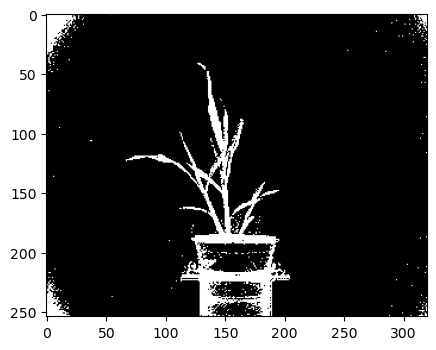

In [17]:
# Perform thresholding to generate a binary image

# Inputs: 
#   gray_img - Grayscale image data 
#   threshold - Threshold value (0-255)
#   max_value - Value to apply above the threshold (255 = white)
#   object_type - 'light' (default) or 'dark'. If the object is lighter than 
#                 the background then standard thresholding is done. If the 
#                 object is darker than the background then inverse thresholding. 
tr_es_img = pcv.threshold.binary(gray_img=edge_shrp_img, threshold=165, 
                                 max_value=255, object_type='dark')


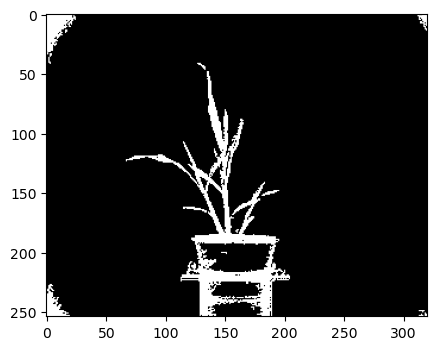

In [18]:
# Use the fill function to get rid of small salt & pepper noise in the image 

# Inputs: 
#   bin_img - Binary image data 
#   size - Minimum object area size in pixels (must be an integer), and smaller objects will be filled
f_img = pcv.fill(bin_img=tr_es_img, size=5)


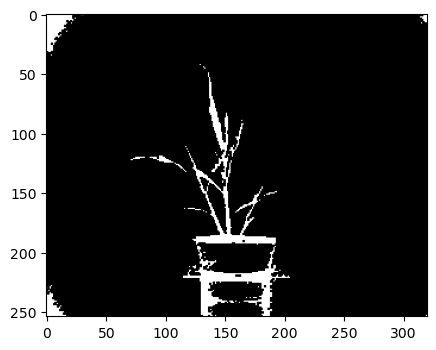

In [19]:
# There is another PlantCV function that can help reduce background 
# noise, and can be used with `pcv.dilate` to avoid losing plant 

# Inputs:
#   gray_img - Grayscale (usually binary) image data 
#   ksize - The size used to build a ksize x ksize 
#            matrix using np.ones. Must be greater than 1 to have an effect 
#   i - An integer for the number of iterations 
eroded_img = pcv.erode(gray_img=tr_es_img, ksize=2, i=1)


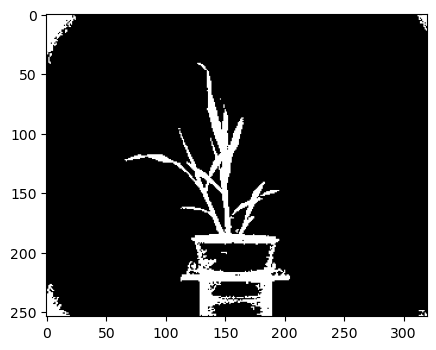

In [20]:
# Bring the two object identification approaches together.
# Using a logical OR combine object identified by background subtraction and the object identified by derivative filter.

# Inputs: 
#   bin_img1 - Binary image data to be compared in bin_img2
#   bin_img2 - Binary image data to be compared in bin_img1
comb_img = pcv.logical_or(bin_img1=f_img, bin_img2=bkg_sub_thres_img)


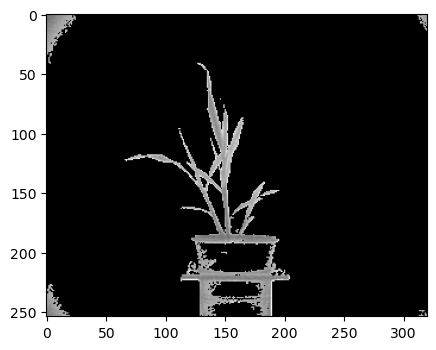

In [21]:
# Get masked image, Essentially identify pixels corresponding to plant and keep those.

# Inputs: 
#   img - RGB or grayscale image data 
#   mask - Binary mask image data 
#   mask_color - 'black' or 'white'
masked_erd = pcv.apply_mask(img=img, mask=comb_img, mask_color='black')


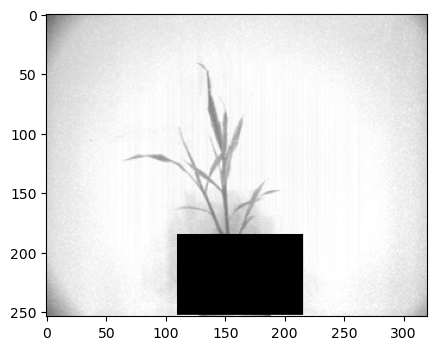

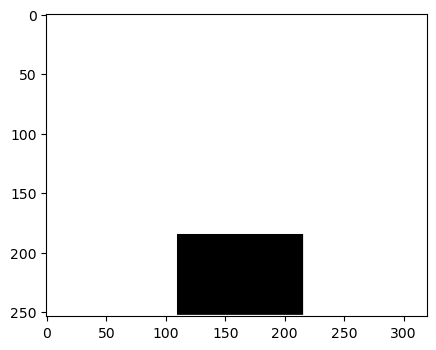

In [22]:
# Need to remove the edges of the image, we did that by generating a set of rectangles to mask the edges
# img is (254 X 320)
# Mask for the bottom of the image

# Inputs:
#   img - RGB or grayscale image data 
#   p1 - Point at the top left corner of the rectangle (tuple)
#   p2 - Point at the bottom right corner of the rectangle (tuple) 
#   color 'black' (default), 'gray', or 'white'
masked1, box1_img, rect_contour1, hierarchy1 = pcv.rectangle_mask(img=img, p1=(110,185), p2=(215,252))


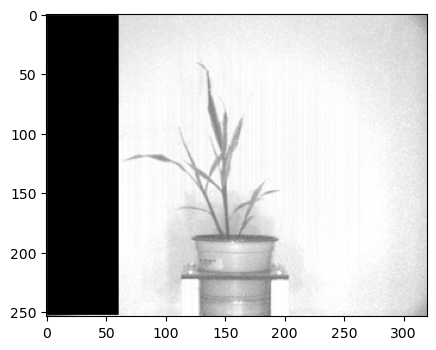

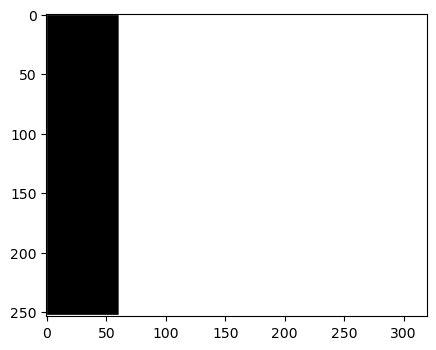

In [23]:
# Mask for the left side of the image

masked2, box2_img, rect_contour2, hierarchy2 = pcv.rectangle_mask(img=img, p1=(1,1), p2=(60,252))


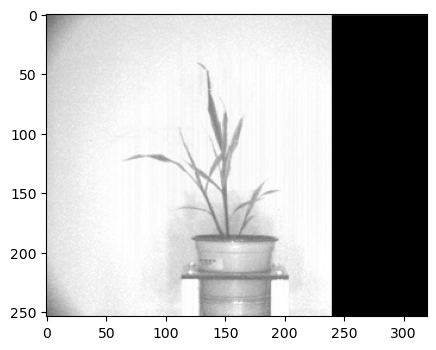

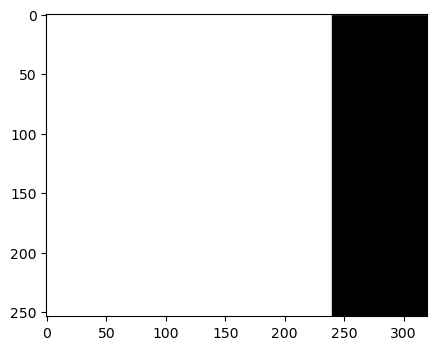

In [24]:
# Mask for the right side of the image

masked3, box3_img, rect_contour3, hierarchy3 = pcv.rectangle_mask(img=img, p1=(240,1), p2=(320,254))


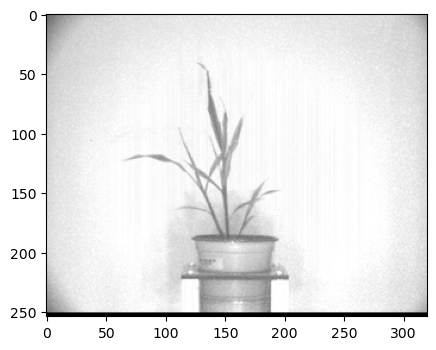

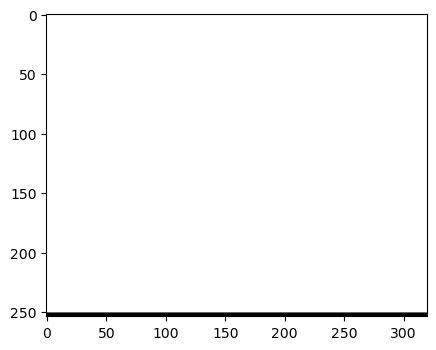

In [25]:
# Mask the bottom edge

masked4, box4_img, rect_contour4, hierarchy4 = pcv.rectangle_mask(img=img, p1=(0,251), p2=(320,254))


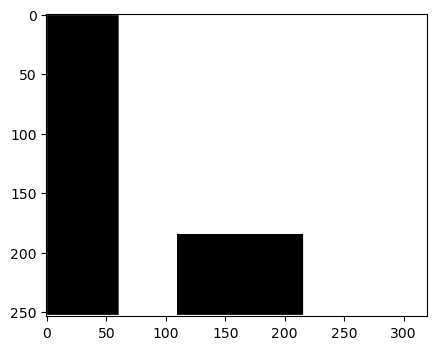

In [26]:
# Combine boxes to filter the edges and car out of the photo

# Inputs: 
#   bin_img1 - Binary image data to be compared in bin_img2
#   bin_img2 - Binary image data to be compared in bin_img1
bx12_img = pcv.logical_and(bin_img1=box1_img, bin_img2=box2_img)


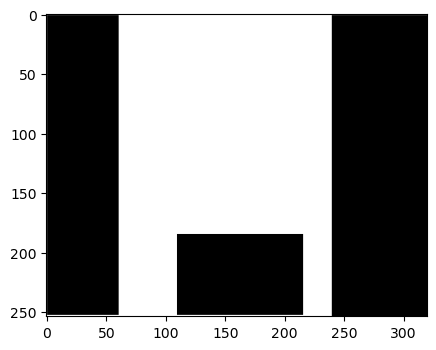

In [27]:
bx123_img = pcv.logical_and(bin_img1=bx12_img, bin_img2=box3_img)


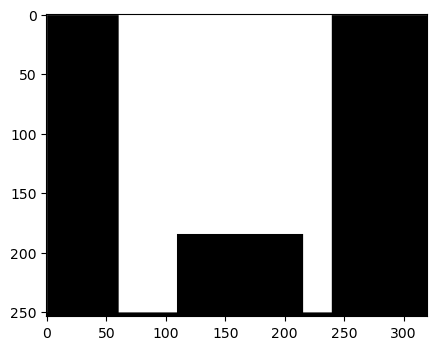

In [28]:
bx1234_img = pcv.logical_and(bin_img1=bx123_img, bin_img2=box4_img)


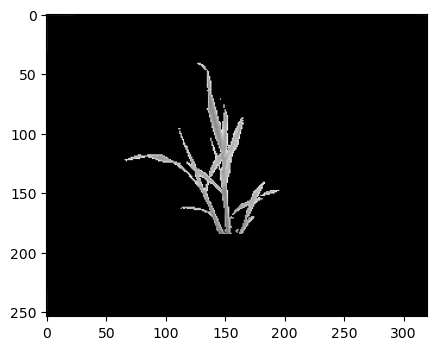

In [29]:
edge_masked_img = pcv.apply_mask(img=masked_erd, mask=bx1234_img, mask_color='black')


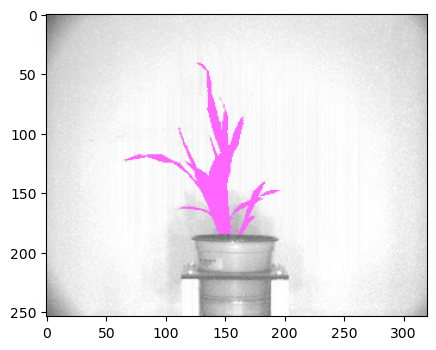

In [30]:
# Identify objects

# Inputs:
#   img - RGB or grayscale image data for plotting
#   mask - Binary mask used for detecting contours
id_objects, obj_hierarchy = pcv.find_objects(img=img, mask=edge_masked_img)


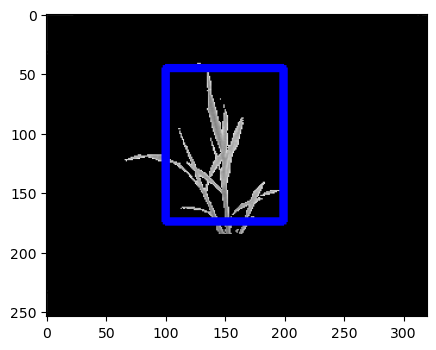

In [31]:
# Define ROI

# Inputs: 
#   img - RGB or grayscale image to plot the ROI on 
#   x - The x-coordinate of the upper left corner of the rectangle 
#   y - The y-coordinate of the upper left corner of the rectangle 
#   h - The height of the rectangle 
#   w - The width of the rectangle 
roi1, roi_hierarchy= pcv.roi.rectangle(img=edge_masked_img, x=100, y=45, h=130, w=100)


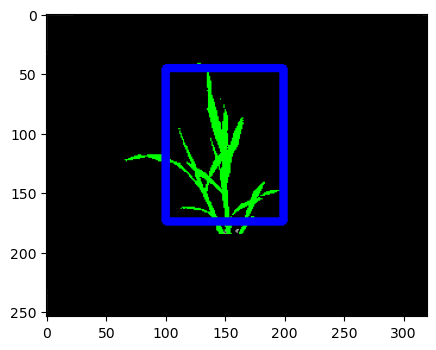

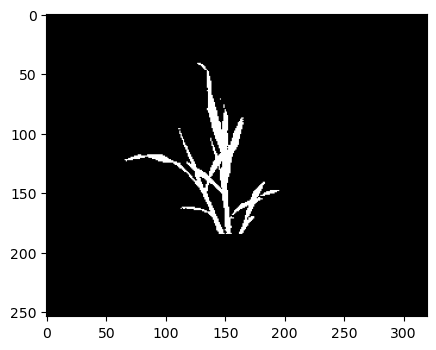

In [32]:
# Decide which objects to keep

# Inputs:
#    img            = img to display kept objects
#    roi_contour    = contour of roi, output from any ROI function
#    roi_hierarchy  = contour of roi, output from any ROI function
#    object_contour = contours of objects, output from pcv.find_objects function
#    obj_hierarchy  = hierarchy of objects, output from pcv.find_objects function
#    roi_type       = 'partial' (default, for partially inside the ROI), 'cutto', or 
#                     'largest' (keep only largest contour)
roi_objects, hierarchy5, kept_mask, obj_area = pcv.roi_objects(img=edge_masked_img, roi_contour=roi1, 
                                                               roi_hierarchy=roi_hierarchy, object_contour=id_objects, 
                                                               obj_hierarchy=obj_hierarchy, roi_type='partial')


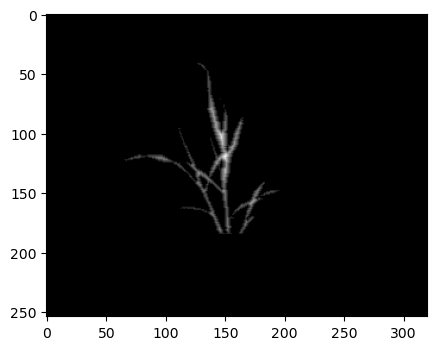

In [33]:
# We can perform a distance transformation on a binary image 
# that can assist with object segmentation 

# Inputs:
#   bin_img - Binary image data 
#   distance_type - Type of distance. It can be CV_DIST_L1, CV_DIST_L2 , 
#                   or CV_DIST_C which are 1,2 and 3 respectively.
#   mask_size - Size of the distance transform mask. It can be 3, 5, 
#               or CV_DIST_MASK_PRECISE (the latter option is only supported 
#               by the first function). In case of the CV_DIST_L1 or 
#               CV_DIST_C distance type, the parameter is forced to 3 because 
#               a 3 by 3 mask gives the same result as 5 by 5 or any larger aperture.
dist_img = pcv.distance_transform(bin_img=kept_mask, distance_type=1, mask_size=3)


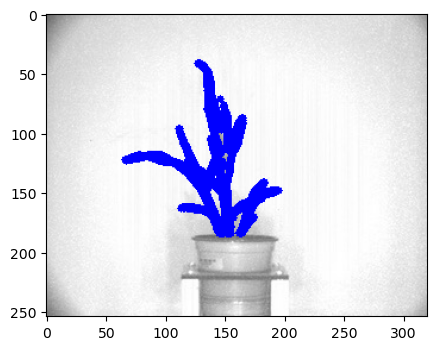

In [34]:
# Use the object_composition function to outline the plant 
# Inputs:
#   img - RGB or grayscale image data for plotting 
#   contours - Contour list 
#   hierarchy - Contour hierarchy array 
grp_object, img_mask = pcv.object_composition(img=img, contours=roi_objects, 
                                              hierarchy=hierarchy5)


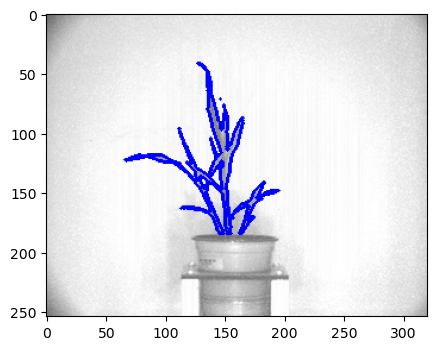

In [35]:
# The outline is too thick for an image this size. Change the line_thickness from it's default of 5 and rerun
pcv.params.line_thickness = 2

grp_object, img_mask = pcv.object_composition(img=img, contours=roi_objects, 
                                              hierarchy=hierarchy5)


Now we can perform the analysis of pixelwise signal value and object shape attributes.


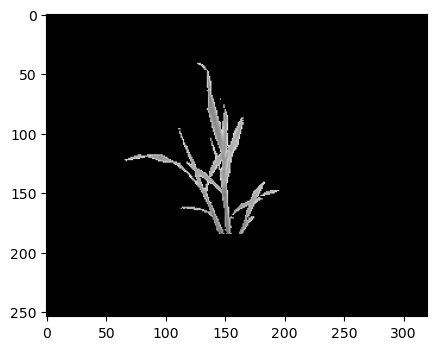

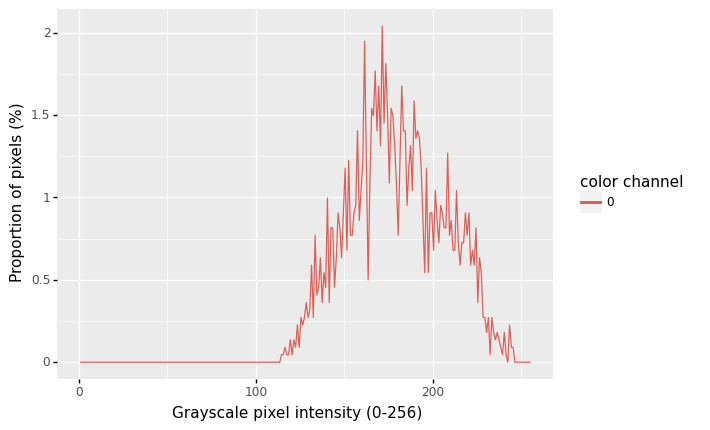

In [36]:
# Perform NIR signal analysis 

# Inputs: 
#   gray_img - 8 or 16-bit grayscale image data 
#   mask - Binary mask made from selected contours 
#   bins - Number of classes to divide the spectrum into 
#   histplot - If True, plots the histogram of intensity values 
#   label - Optional label parameter, modifies the variable name of observations recorded. (default `label="default"`)filled_img = pcv.morphology.fill_segments(mask=cropped_mask, objects=edge_objects)

nir_hist_img = pcv.analyze_nir_intensity(gray_img=img, mask=kept_mask, 
                                         bins=256, histplot=True)



In [37]:
# Print out the NIR histogram that gets returned.
pcv.print_image(img=nir_hist_img, filename="nir_hist.jpg")


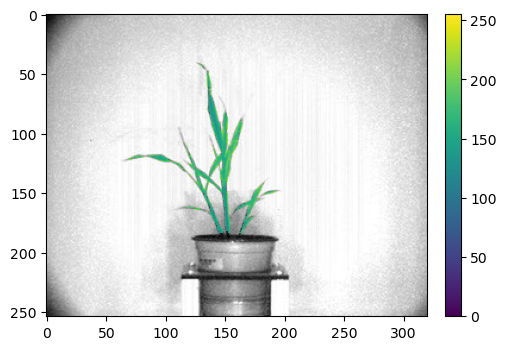

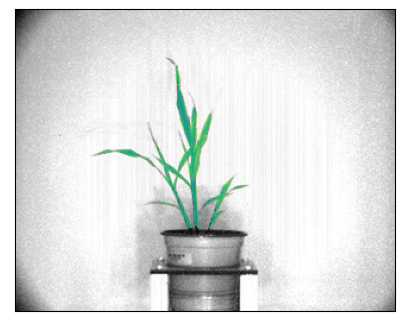

In [38]:
# Inputs:
#     gray_img - Grayscale image data
#     obj - Single or grouped contour object (optional), if provided the pseudocolored image gets cropped down to the region of interest.
#     mask - Binary mask (optional) 
#     background - Background color/type. Options are "image" (gray_img), "white", or "black". A mask must be supplied.
#     cmap - Colormap
#     min_value - Minimum value for range of interest
#     max_value - Maximum value for range of interest
#     dpi - Dots per inch for image if printed out (optional, if dpi=None then the default is set to 100 dpi).
#     axes - If False then the title, x-axis, and y-axis won't be displayed (default axes=True).
#     colorbar - If False then the colorbar won't be displayed (default colorbar=True)

# Pseudocolor the NIR grayscale image 
pseudocolored_img = pcv.visualize.pseudocolor(gray_img=img, obj=None, mask=kept_mask, cmap='viridis')

# Plot with the option background='image'
simple_pseudo_img = pcv.visualize.pseudocolor(gray_img=img, obj=None, mask=kept_mask, background="image", 
                                              axes=False, colorbar=False, cmap='viridis')



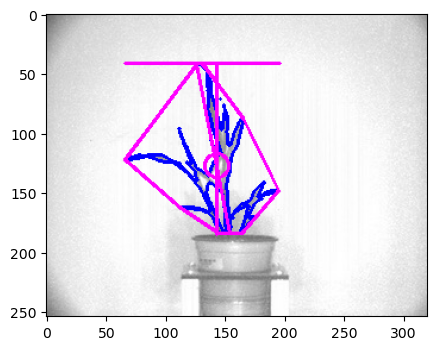

In [39]:
# Perform shape analysis

# Inputs:
#   img - RGB or grayscale image data 
#   obj- Single or grouped contour object
#   mask - Binary image mask to use as mask for moments analysis 
#   label - Optional label parameter, modifies the variable name of observations recorded. (default `label="default"`)filled_img = pcv.morphology.fill_segments(mask=cropped_mask, objects=edge_objects)

shape_imgs = pcv.analyze_object(img=img, obj=grp_object, mask=img_mask)


In [40]:
# The save results function will take the measurements stored when running any PlantCV analysis functions, format, 
# and print an output text file for data analysis. The Outputs class stores data whenever any of the following functions
# are ran: analyze_bound_horizontal, analyze_bound_vertical, analyze_color, analyze_nir_intensity, analyze_object, 
# fluor_fvfm, report_size_marker_area, watershed. If no functions have been run, it will print an empty text file 
pcv.outputs.save_results(filename=args.result)


To view and/or download the text file output (saved in JSON format)...
1) To see the text file with data that got saved out, click “File” tab in top left corner.
2) Click “Open…”
3) Open the file named “nir_tutorial_results.txt”

Check out documentation on how to [convert JSON](https://plantcv.readthedocs.io/en/latest/tools/#convert-output-json-data-files-to-csv-tables) format output into table formatted output. Depending on the analysis steps a PlantCV user may have two CSV files (single value traits and multivalue traits). 

